In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-0t4qr77d
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-0t4qr77d
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=010b2d15462f9356f6e630f14cd41a1b4527c487bf20f017c08f29223cafea9a
  Stored in directory: /tmp/pip-ephem-wheel-cache-0ztglqv4/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
# from google.colab import files
# files.upload()

from google.colab import drive
drive.mount('/content/gdrive')

!unzip /content/gdrive/MyDrive/DL/100-bird-species.zip -d /content/100-bird-species

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/120.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/121.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/122.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/123.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/124.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/125.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/126.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/127.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/128.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/129.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/130.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/131.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC

In [3]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision

import clip
from PIL import Image
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 83.6MiB/s]


In [7]:
# Defining dataset path
data_dir = '/content/100-bird-species/'
train_dir = data_dir + 'train/'
valid_dir = data_dir + 'valid/'

In [8]:
# Defining train transform and val transform along with data
train_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor()
])

val_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor()
])

In [9]:
#Creating dataset
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(valid_dir,transform=val_transform)

In [10]:
batch_size = 128
# Creating dataloader
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size, shuffle=True)

In [11]:
# Defining num of classes
num_classes = len(train_dataset.classes)
print(num_classes)

525


In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
# Pushing data to device
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, images, labels):
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, images, labels):
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [16]:
class BirdSpeciesCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.clip = clip_model.visual
        self.network = nn.Sequential(
            nn.Linear(512, 640),
            nn.ReLU(),
            nn.Linear(640, num_classes))

    def forward(self, xb):
        xb = self.clip(xb)
        return self.network(xb.to(device))

In [17]:
model = BirdSpeciesCnnModel()
model

BirdSpeciesCnnModel(
  (clip): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=Tru

In [18]:
transform = transforms.ToPILImage()

In [19]:
from tqdm import tqdm
import copy

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = list()
    for images, labels in tqdm(val_loader):
      new_images = []
      for i, image in enumerate(images):
        image_input = preprocess(transform(image)).unsqueeze(0).to(device)
        image_input = image_input.squeeze()
        new_images.append(np.asarray(image_input.cpu()))
      new_images = np.asarray(new_images)
      new_images = torch.from_numpy(new_images)
      new_images = new_images.to(device)
      labels = labels.to(device)
      outputs.append(model.validation_step(new_images, labels))
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [20]:
def fit(epochs, lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for images, labels in tqdm(train_loader):
            new_images = []
            for i, image in enumerate(images):
              image_input = preprocess(transform(image)).unsqueeze(0).to(device)
              image_input = image_input.squeeze()
              new_images.append(np.asarray(image_input.cpu()))
            new_images = np.asarray(new_images)
            new_images = torch.from_numpy(new_images)

            new_images = new_images.to(device)
            loss = model.training_step(new_images, labels)
            train_losses.append(loss)
            loss.backward()
            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
model = BirdSpeciesCnnModel()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(valid_loader, device)
to_device(model, device)
epochs = 10
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 2e-8
opt_func = torch.optim.Adam

In [22]:
if torch.cuda.is_available():
  model = model.type(torch.cuda.FloatTensor)
history = fit(epochs, max_lr, model, train_loader, valid_loader, weight_decay, grad_clip, opt_func)

100%|██████████| 21/21 [00:17<00:00,  1.18it/s]


Epoch [0], last_lr: 0.00003, train_loss: 5.3349, val_loss: 2.8380, val_acc: 0.6763


100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Epoch [1], last_lr: 0.00008, train_loss: 1.3114, val_loss: 0.8145, val_acc: 0.8116


100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Epoch [2], last_lr: 0.00010, train_loss: 0.7317, val_loss: 0.5096, val_acc: 0.8621


100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Epoch [3], last_lr: 0.00010, train_loss: 0.4788, val_loss: 0.3442, val_acc: 0.9097


100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Epoch [4], last_lr: 0.00008, train_loss: 0.2821, val_loss: 0.3336, val_acc: 0.9078


100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Epoch [5], last_lr: 0.00006, train_loss: 0.1610, val_loss: 0.2129, val_acc: 0.9420


100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Epoch [6], last_lr: 0.00004, train_loss: 0.0631, val_loss: 0.1606, val_acc: 0.9583


100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Epoch [7], last_lr: 0.00002, train_loss: 0.0201, val_loss: 0.1247, val_acc: 0.9688


100%|██████████| 21/21 [00:17<00:00,  1.23it/s]


Epoch [8], last_lr: 0.00000, train_loss: 0.0070, val_loss: 0.1194, val_acc: 0.9717


100%|██████████| 21/21 [00:17<00:00,  1.23it/s]

Epoch [9], last_lr: 0.00000, train_loss: 0.0037, val_loss: 0.1185, val_acc: 0.9729


In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

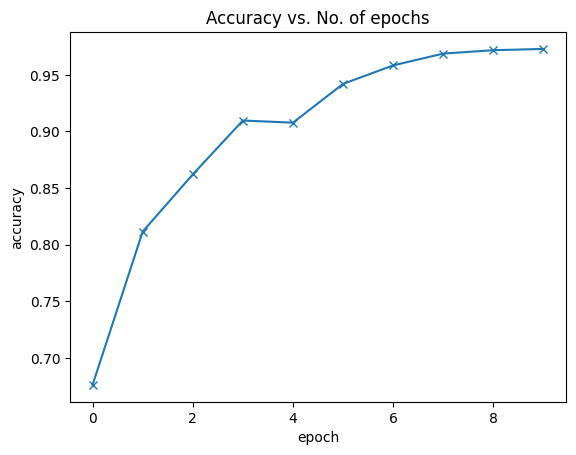

In [24]:
plot_accuracies(history)

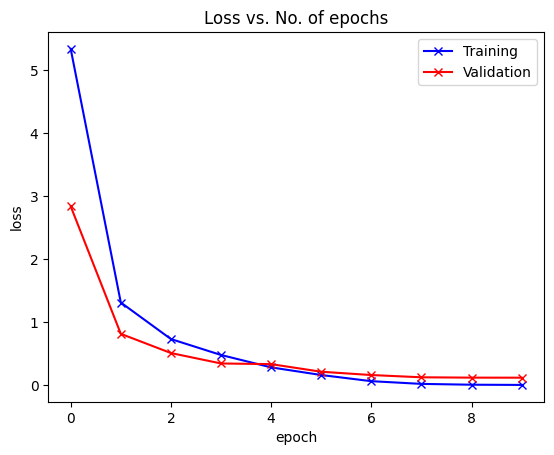

In [25]:
plot_losses(history)

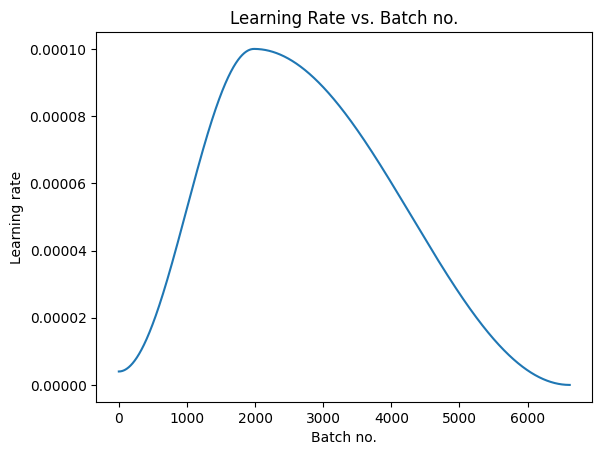

In [26]:
plot_lrs(history)

In [27]:
test_dataset = ImageFolder(data_dir+'/test', transform=val_transform)
test_loader = DeviceDataLoader(DataLoader(test_dataset, 1), device)
result = evaluate(model, test_loader)
result

100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


{'val_loss': 0.06656040996313095, 'val_acc': 0.9815778136253357}

In [28]:
torch.save(model.state_dict(), 'Clip08.pth')

In [99]:
@torch.no_grad()
def evaluate_with_class_accuracy(model, val_loader):
    model.eval()
    outputs = []
    wellPred = {}
    wrongPred = {}
    class_correct = {i: 0 for i in range(num_classes)}
    class_total = {i: 0 for i in range(num_classes)}

    for images, labels in tqdm(val_loader):
        new_images = []
        for i, image in enumerate(images):
          image_input = preprocess(transform(image)).unsqueeze(0).to(device)
          image_input = image_input.squeeze()
          new_images.append(np.asarray(image_input.cpu()))
        new_images = np.asarray(new_images)
        new_images = torch.from_numpy(new_images)
        new_images = new_images.to(device)

        labels = labels.to(device)

        preds = model(new_images)
        _, predicted = torch.max(preds, 1)

        # Update class_correct and class_total
        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            class_correct[label] += (label == pred)
            class_total[label] += 1

            image_np = images[i]
            image_np = image_np.detach().cpu().numpy()
            if image_np.shape[0] == 3:
                image_np = np.transpose(image_np, (1, 2, 0))

            if(label != pred):
                if label not in wrongPred:
                    wrongPred[label] = []
                wrongPred[label].append({'label':test_dataset.classes[label], 'pred': test_dataset.classes[pred], 'image': image_np})
            else:
                if label not in wellPred:
                    wellPred[label] = []
                wellPred[label].append({'label':test_dataset.classes[label], 'pred': test_dataset.classes[pred], 'image': image_np})

        # Append outputs
        outputs.append(model.validation_step(images, labels))

    # Calculate overall accuracy
    overall_accuracy = sum(class_correct.values()) / sum(class_total.values())

    # Calculate class-wise accuracy
    class_accuracy = {i: class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)}

    # Print class-wise accuracy
    for i in range(num_classes):
        print(f'Accuracy of {test_dataset.classes[i]}: {class_accuracy[i]:.4f}')

    # Return overall accuracy and class-wise accuracy
    return {'overall_accuracy': overall_accuracy, 'class_accuracy': class_accuracy}, wellPred, wrongPred

In [100]:
result_with_class_accuracy, wellPred, wrongPred = evaluate_with_class_accuracy(model, test_loader)
print(result_with_class_accuracy)

100%|██████████| 2625/2625 [01:49<00:00, 23.97it/s]


Accuracy of ABBOTTS BABBLER: 1.0000
Accuracy of ABBOTTS BOOBY: 1.0000
Accuracy of ABYSSINIAN GROUND HORNBILL: 1.0000
Accuracy of AFRICAN CROWNED CRANE: 1.0000
Accuracy of AFRICAN EMERALD CUCKOO: 1.0000
Accuracy of AFRICAN FIREFINCH: 1.0000
Accuracy of AFRICAN OYSTER CATCHER: 1.0000
Accuracy of AFRICAN PIED HORNBILL: 1.0000
Accuracy of AFRICAN PYGMY GOOSE: 1.0000
Accuracy of ALBATROSS: 1.0000
Accuracy of ALBERTS TOWHEE: 1.0000
Accuracy of ALEXANDRINE PARAKEET: 1.0000
Accuracy of ALPINE CHOUGH: 1.0000
Accuracy of ALTAMIRA YELLOWTHROAT: 0.8000
Accuracy of AMERICAN AVOCET: 1.0000
Accuracy of AMERICAN BITTERN: 1.0000
Accuracy of AMERICAN COOT: 1.0000
Accuracy of AMERICAN DIPPER: 1.0000
Accuracy of AMERICAN FLAMINGO: 1.0000
Accuracy of AMERICAN GOLDFINCH: 1.0000
Accuracy of AMERICAN KESTREL: 1.0000
Accuracy of AMERICAN PIPIT: 1.0000
Accuracy of AMERICAN REDSTART: 1.0000
Accuracy of AMERICAN ROBIN: 1.0000
Accuracy of AMERICAN WIGEON: 1.0000
Accuracy of AMETHYST WOODSTAR: 1.0000
Accuracy of AN

In [101]:
def print_pred(Pred):
  # Define the number of rows and columns for subplots
  num_rows = int(sum([len(examples) for examples in Pred.values()]) / 5) + 1
  num_cols = 5
  row = 0

  # Counter for total subplots
  plt.figure(figsize=(20, 20))

  subplot_counter = 1
  # Loop through each class in Pred
  for class_label, examples in Pred.items():
      # Loop through each example for the current class
      for example in examples:
          # Create a new subplot
          plt.subplot(num_rows, num_cols, subplot_counter)

          # Extract information from the example
          image_np = example['image']
          label = example['label']
          pred = example['pred']

          # Display the image
          plt.imshow(image_np)
          plt.title(f'TRUE: {label}\nPRED: {pred}', fontsize=8)
          plt.axis('off')

          # Increment the subplot counter
          subplot_counter += 1

  plt.subplots_adjust(wspace=0.1, hspace=0.5)
  plt.show()

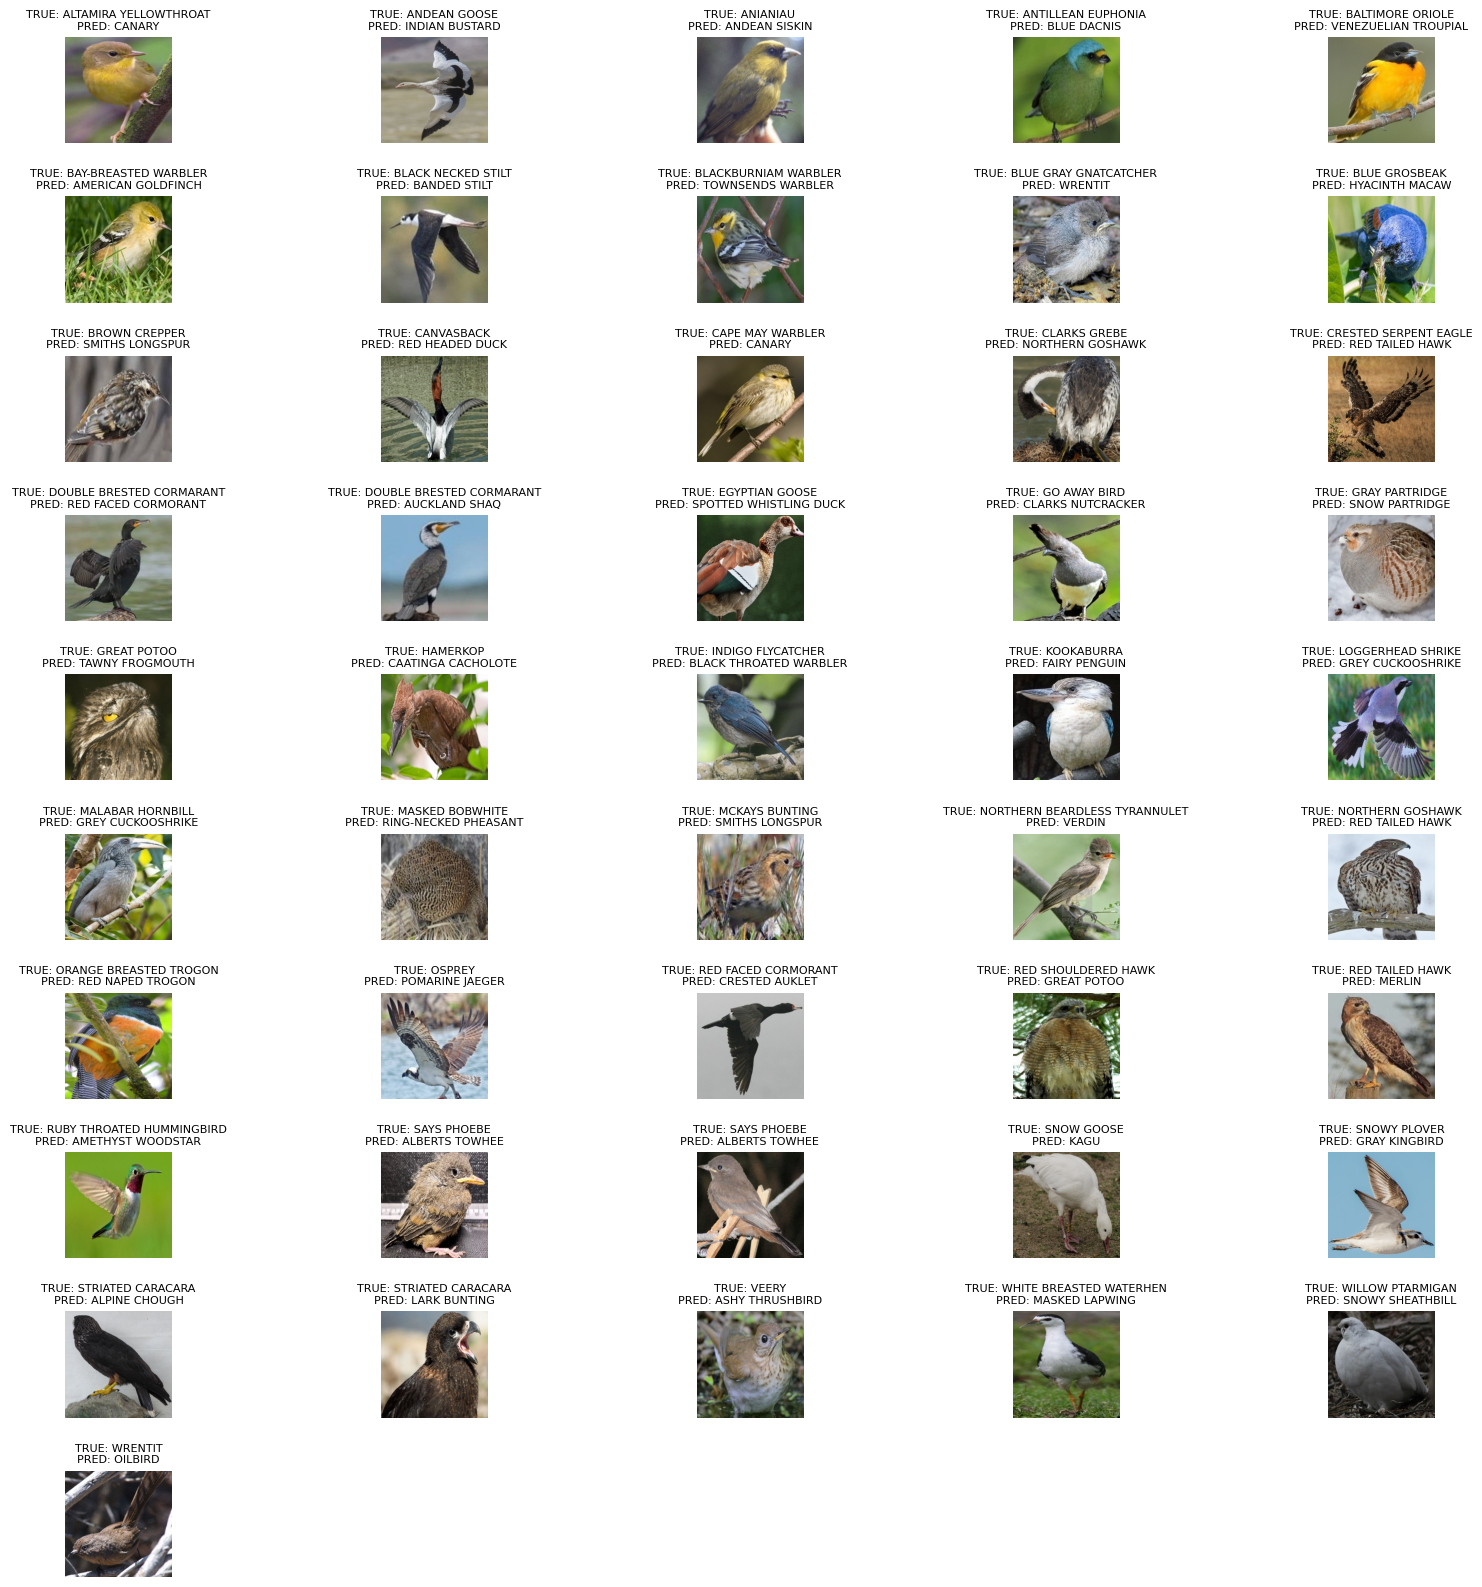

In [102]:
print_pred(wrongPred)

In [107]:
count_wrong = {}

for class_label, examples in wrongPred.items():
      count_wrong[class_label] = len(examples)

sorted_wrong = sorted(count_wrong.items(), key=lambda x: x[1], reverse=True)

for i in sorted_wrong:
    print(f'class: {test_dataset.classes[i[0]]} - count: {i[1]}')

class: DOUBLE BRESTED CORMARANT - count: 2
class: SAYS PHOEBE - count: 2
class: STRIATED CARACARA - count: 2
class: ALTAMIRA YELLOWTHROAT - count: 1
class: ANDEAN GOOSE - count: 1
class: ANIANIAU - count: 1
class: ANTILLEAN EUPHONIA - count: 1
class: BALTIMORE ORIOLE - count: 1
class: BAY-BREASTED WARBLER - count: 1
class: BLACK NECKED STILT - count: 1
class: BLACKBURNIAM WARBLER - count: 1
class: BLUE GRAY GNATCATCHER - count: 1
class: BLUE GROSBEAK - count: 1
class: BROWN CREPPER - count: 1
class: CANVASBACK - count: 1
class: CAPE MAY WARBLER - count: 1
class: CLARKS GREBE - count: 1
class: CRESTED SERPENT EAGLE - count: 1
class: EGYPTIAN GOOSE - count: 1
class: GO AWAY BIRD - count: 1
class: GRAY PARTRIDGE - count: 1
class: GREAT POTOO - count: 1
class: HAMERKOP - count: 1
class: INDIGO FLYCATCHER - count: 1
class: KOOKABURRA - count: 1
class: LOGGERHEAD SHRIKE - count: 1
class: MALABAR HORNBILL - count: 1
class: MASKED BOBWHITE - count: 1
class: MCKAYS BUNTING - count: 1
class: NOR

In [98]:
test_dataset = ImageFolder(data_dir+'/test', transform=val_transform)
test_loader = DeviceDataLoader(DataLoader(test_dataset, 1), device)
result = evaluate(model, test_loader)
result

100%|██████████| 2625/2625 [01:04<00:00, 40.66it/s]


{'val_loss': 0.06365911662578583, 'val_acc': 0.9824761748313904}